In [68]:
import pandas as pd 

sales_transactions = pd.read_csv("sales_transactions.csv")

# Aggregate total sales per customer
customer_sales = sales_transactions.groupby("Customer ID")["Total Sales"].sum().reset_index()

# Define segmentation criteria based on percentiles
high_threshold = customer_sales["Total Sales"].quantile(0.75)  # Top 25%
low_threshold = customer_sales["Total Sales"].quantile(0.25)   # Bottom 25%

# Function to assign Customer Tier
def categorize_customer(sales):
    if sales >= high_threshold:
        return "High-Value"
    elif sales >= low_threshold:
        return "Mid-Tier"
    else:
        return "Low-Value"

# Apply categorization
customer_sales["Customer Tier"] = customer_sales["Total Sales"].apply(categorize_customer)

# Verify the results
print(customer_sales.head())


   Customer ID  Total Sales Customer Tier
0            1    146941.22    High-Value
1            2     83056.35     Low-Value
2            3    105387.01      Mid-Tier
3            4    119775.16      Mid-Tier
4            5     94324.30     Low-Value


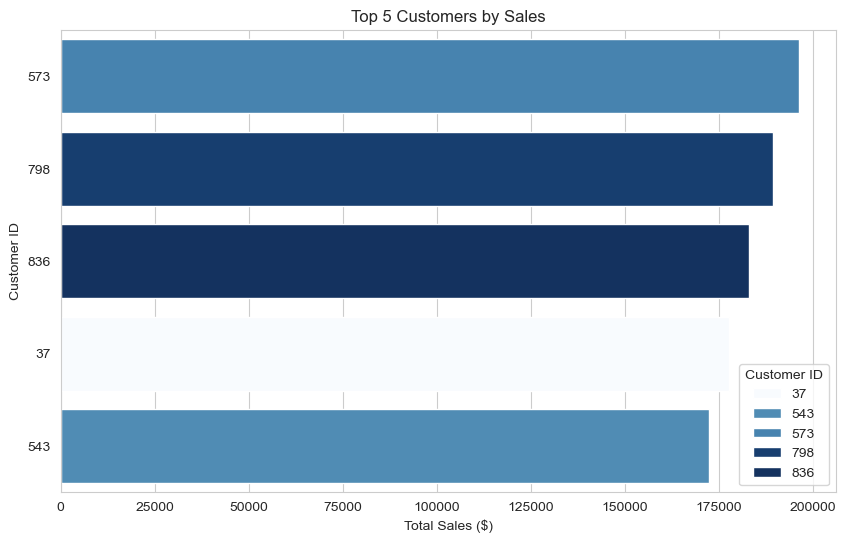

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns


# Aggregate total sales per customer
top_customers = sales_transactions.groupby("Customer ID")["Total Sales"].sum().reset_index()

# Sort the total sales in descending order and select top 5
top_customers = top_customers.sort_values(by="Total Sales", ascending=False).head(5)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Total Sales", y=top_customers["Customer ID"].astype(str), data=top_customers, hue="Customer ID", palette="Blues")

plt.xlabel("Total Sales ($)")
plt.ylabel("Customer ID")
plt.title("Top 5 Customers by Sales")
plt.show()

C:\Users\sudchan\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


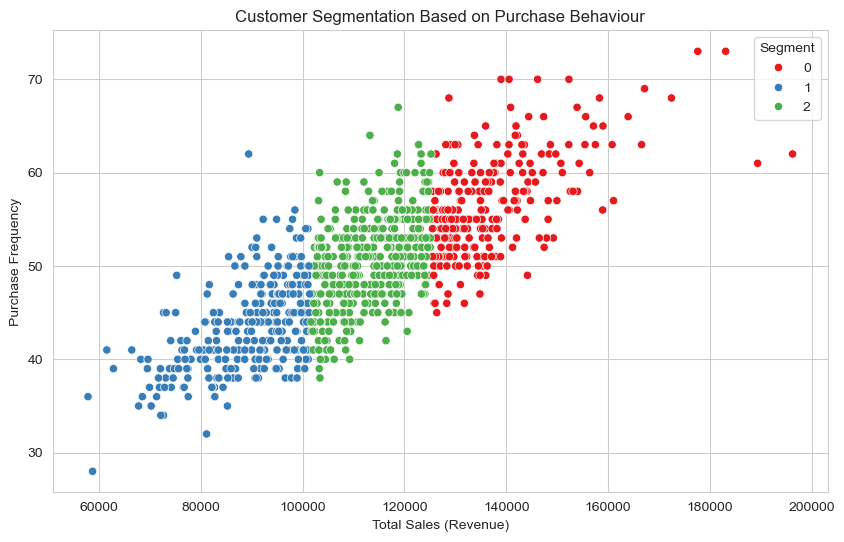

    Customer ID  Total_Sales  Purchase_Frequency  Segment
0             1    146941.22                  62        0
1             2     83056.35                  42        1
2             3    105387.01                  54        2
3             4    119775.16                  52        2
4             5     94324.30                  45        1
5             6    107533.56                  50        2
6             7     99549.91                  50        1
7             8     88632.62                  50        1
8             9    123653.38                  50        2
9            10     80723.23                  44        1
10           11    135993.89                  49        0
11           12     87435.01                  41        1
12           13    155625.86                  66        0
13           14     99624.07                  50        1
14           15    132225.44                  51        0
15           16    143570.04                  63        0
16           1

In [70]:
from sklearn.cluster import KMeans

# Aggregating total revenue and purchase frequency per customer
customer_data = sales_transactions.groupby("Customer ID").agg(
    Total_Sales=("Total Sales", "sum"),
    Purchase_Frequency=("Customer ID", "count")
).reset_index()

# Applying K-Means clustering
kmeans = KMeans(n_clusters=3,  random_state=42)
customer_data["Segment"] = kmeans.fit_predict(customer_data[["Total_Sales", "Purchase_Frequency"]])

# Visualize customer segment
plt.figure(figsize=(10,6))
sns.scatterplot(x="Total_Sales", y="Purchase_Frequency", hue=customer_data["Segment"], palette="Set1", data=customer_data)

#Labels and Title
plt.xlabel("Total Sales (Revenue)")
plt.ylabel("Purchase Frequency")
plt.title("Customer Segmentation Based on Purchase Behaviour")
plt.legend(title="Segment")
plt.show()

print(customer_data.head(20))

In [71]:
# Count the number of customers in each cluster
cluster_counts = customer_data["Segment"].value_counts()


print(cluster_counts)

Segment
2    446
1    303
0    251
Name: count, dtype: int64


In [72]:
# Analyze average total sales for each segment
segment_profile = customer_data.groupby("Segment")["Total_Sales"].mean().reset_index()

# Rename columns for clarity
segment_profile.columns = ["Segment", "Average Sales"]


print(segment_profile)

   Segment  Average Sales
0        0  137261.361633
1        1   89689.480000
2        2  113240.126009


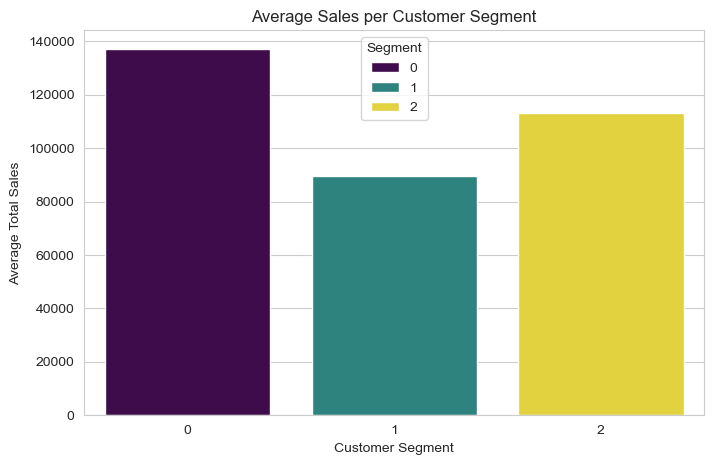

In [73]:
# Set visualization style
sns.set_style("whitegrid")

# Plot average sales per segment
plt.figure(figsize=(8,5))
sns.barplot(x="Segment", y="Average Sales", data=segment_profile, hue="Segment", palette="viridis")

plt.xlabel("Customer Segment")
plt.ylabel("Average Total Sales")
plt.title("Average Sales per Customer Segment")

plt.show()

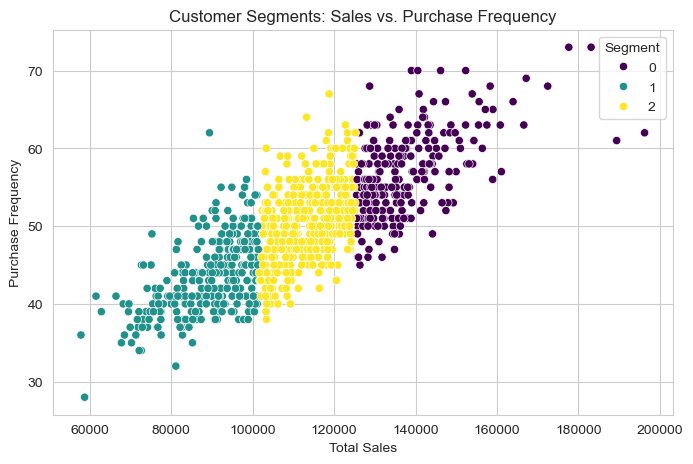

In [74]:
# Scatter plot of Total Sales vs. Number of Transactions
plt.figure(figsize=(8,5))
sns.scatterplot(x=customer_data["Total_Sales"],
                y=customer_data["Purchase_Frequency"],
                hue=customer_data["Segment"],
                palette="viridis")

plt.xlabel("Total Sales")
plt.ylabel("Purchase Frequency")
plt.title("Customer Segments: Sales vs. Purchase Frequency")
plt.legend(title="Segment")

plt.show()

In [75]:
# Convert Order date to datetime format
sales_transactions["Order Date"] = pd.to_datetime(sales_transactions["Order Date"])

# Get the first purchase date for each customer
first_purchase = sales_transactions.groupby("Customer ID")["Order Date"].min().reset_index()
first_purchase.columns = ["Customer ID", "First Purchase Date"]

# Merge this with original transactions to track repeat purchases
sales_transactions = sales_transactions.merge(first_purchase, on="Customer ID", how="left")

# Check if the purchase date is different from the first purchase date (repeat purchase)
sales_transactions["Repeat Customer"] = sales_transactions["Order Date"] > sales_transactions["First Purchase Date"]

# Calculate the retention rate (percentage of repeat customers)
retention_rate = sales_transactions["Repeat Customer"].mean()

print(f"Customer Retention Rate: {retention_rate: .2%}")
print(sales_transactions.head(5))

Customer Retention Rate:  98.00%
   Transaction ID  Customer ID  Product ID  Employee ID  Region ID  \
0               1          273          25           93          1   
1               2          690          47           11          4   
2               3          368          31           49          5   
3               4          989           4           94          4   
4               5          716          50           64          4   

   Quantity Sold  Discount          Order Date   Price  Total Sales  \
0              9      0.19 2023-01-01 00:00:00  159.53      1162.97   
1              4      0.19 2023-01-01 01:00:00  489.29      1585.30   
2              4      0.24 2023-01-01 02:00:00  290.56       883.30   
3              8      0.16 2023-01-01 03:00:00  152.04      1021.71   
4              1      0.07 2023-01-01 04:00:00  185.38       172.40   

  First Purchase Date  Repeat Customer  
0 2023-01-01 00:00:00            False  
1 2023-01-01 01:00:00            Fals

In [76]:
# Ensure 'Order Date' and 'First Purchase Date' are in datetime format
sales_transactions["Order Date"] = pd.to_datetime(sales_transactions["Order Date"])
sales_transactions["First Purchase Date"] = pd.to_datetime(sales_transactions["First Purchase Date"])

# Extract Year-Month from dates
sales_transactions["Order Year-Month"] = sales_transactions["Order Date"].dt.to_period("M")
sales_transactions["First Purchase Year-Month"] = sales_transactions["First Purchase Date"].dt.to_period("M")

# Verify the transformation
print(sales_transactions[["Customer ID", "Order Date", "First Purchase Date", "Order Year-Month", "First Purchase Year-Month"]].head())



   Customer ID          Order Date First Purchase Date Order Year-Month  \
0          273 2023-01-01 00:00:00 2023-01-01 00:00:00          2023-01   
1          690 2023-01-01 01:00:00 2023-01-01 01:00:00          2023-01   
2          368 2023-01-01 02:00:00 2023-01-01 02:00:00          2023-01   
3          989 2023-01-01 03:00:00 2023-01-01 03:00:00          2023-01   
4          716 2023-01-01 04:00:00 2023-01-01 04:00:00          2023-01   

  First Purchase Year-Month  
0                   2023-01  
1                   2023-01  
2                   2023-01  
3                   2023-01  
4                   2023-01  


In [77]:
# Count total customers in each first purchase month
cohort_customers = sales_transactions.groupby("First Purchase Year-Month")["Customer ID"].nunique()

# Count how many of those customers made purchases in later months
monthly_retention = sales_transactions.groupby(["First Purchase Year-Month", "Order Year-Month"])["Customer ID"].nunique().unstack()

# Convert to retention percentage
monthly_retention_percentage = monthly_retention.divide(cohort_customers, axis=0) * 100

print(monthly_retention_percentage)

Order Year-Month           2023-01     2023-02     2023-03     2023-04  \
First Purchase Year-Month                                                
2023-01                      100.0   48.197343   54.079696   51.612903   
2023-02                        NaN  100.000000   46.086957   53.913043   
2023-03                        NaN         NaN  100.000000   50.406504   
2023-04                        NaN         NaN         NaN  100.000000   
2023-05                        NaN         NaN         NaN         NaN   
2023-06                        NaN         NaN         NaN         NaN   
2023-07                        NaN         NaN         NaN         NaN   
2023-08                        NaN         NaN         NaN         NaN   
2023-09                        NaN         NaN         NaN         NaN   
2023-10                        NaN         NaN         NaN         NaN   
2023-11                        NaN         NaN         NaN         NaN   
2023-12                        NaN    

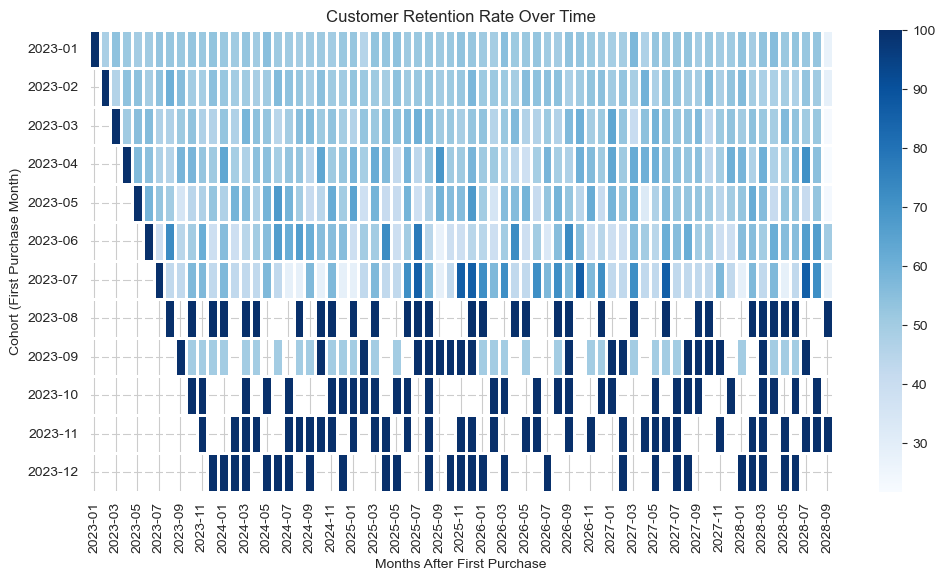

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(monthly_retention_percentage, cmap="Blues", linewidths=1)
plt.title("Customer Retention Rate Over Time")
plt.xlabel("Months After First Purchase")
plt.ylabel("Cohort (First Purchase Month)")
plt.show()

In [79]:
print(cohort_customers)

First Purchase Year-Month
2023-01    527
2023-02    230
2023-03    123
2023-04     55
2023-05     34
2023-06     18
2023-07      7
2023-08      1
2023-09      2
2023-10      1
2023-11      1
2023-12      1
Freq: M, Name: Customer ID, dtype: int64


In [80]:
print(monthly_retention)

Order Year-Month           2023-01  2023-02  2023-03  2023-04  2023-05  \
First Purchase Year-Month                                                
2023-01                      527.0    254.0    285.0    272.0    263.0   
2023-02                        NaN    230.0    106.0    124.0    125.0   
2023-03                        NaN      NaN    123.0     62.0     68.0   
2023-04                        NaN      NaN      NaN     55.0     31.0   
2023-05                        NaN      NaN      NaN      NaN     34.0   
2023-06                        NaN      NaN      NaN      NaN      NaN   
2023-07                        NaN      NaN      NaN      NaN      NaN   
2023-08                        NaN      NaN      NaN      NaN      NaN   
2023-09                        NaN      NaN      NaN      NaN      NaN   
2023-10                        NaN      NaN      NaN      NaN      NaN   
2023-11                        NaN      NaN      NaN      NaN      NaN   
2023-12                        NaN    

In [81]:
monthly_churn_percentage = 100 - monthly_retention_percentage

print(monthly_churn_percentage)

Order Year-Month           2023-01    2023-02    2023-03    2023-04  \
First Purchase Year-Month                                             
2023-01                        0.0  51.802657  45.920304  48.387097   
2023-02                        NaN   0.000000  53.913043  46.086957   
2023-03                        NaN        NaN   0.000000  49.593496   
2023-04                        NaN        NaN        NaN   0.000000   
2023-05                        NaN        NaN        NaN        NaN   
2023-06                        NaN        NaN        NaN        NaN   
2023-07                        NaN        NaN        NaN        NaN   
2023-08                        NaN        NaN        NaN        NaN   
2023-09                        NaN        NaN        NaN        NaN   
2023-10                        NaN        NaN        NaN        NaN   
2023-11                        NaN        NaN        NaN        NaN   
2023-12                        NaN        NaN        NaN        NaN   

Order

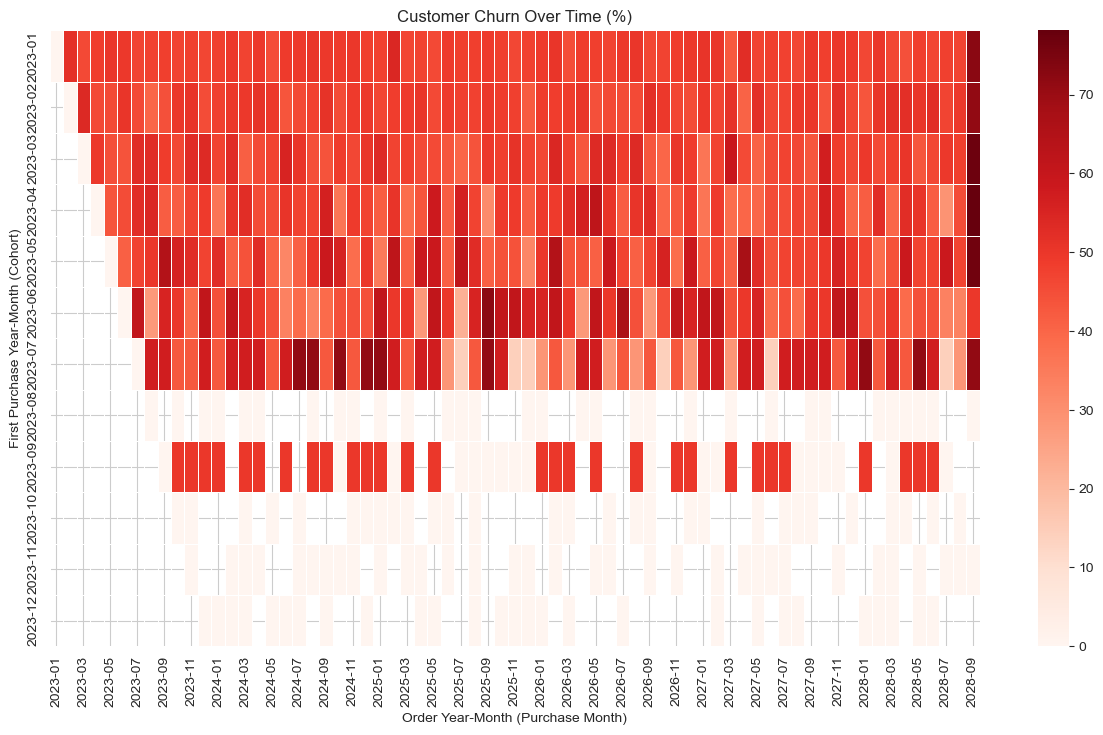

In [82]:
plt.figure(figsize=(15, 8))

sns.heatmap(monthly_churn_percentage, cmap="Reds", linewidth=0.5)

plt.title("Customer Churn Over Time (%)")
plt.xlabel("Order Year-Month (Purchase Month)")
plt.ylabel("First Purchase Year-Month (Cohort)")

plt.show()

In [83]:
# Compute total revenue and number of purchases per customer

customer_revenue = sales_transactions.groupby("Customer ID")["Total Sales"].sum()
customer_purchase = sales_transactions.groupby("Customer ID")["Order Date"].count()

# Compute Average Revenue per Purchase
customer_avg_revenue = customer_revenue/customer_purchase

customer_clv = pd.DataFrame({
    "Total Revenue": customer_revenue,
    "Total Purchases": customer_purchase,
    "Avg Revenue Per Purchase": customer_avg_revenue
})

print(customer_clv.head())

             Total Revenue  Total Purchases  Avg Revenue Per Purchase
Customer ID                                                          
1                146941.22               62               2370.019677
2                 83056.35               42               1977.532143
3                105387.01               54               1951.611296
4                119775.16               52               2303.368462
5                 94324.30               45               2096.095556


In [84]:
# Computing Purchase Frequency

# Count unique months of purchase per customer
customer_purchase_months = sales_transactions.groupby("Customer ID")["Order Year-Month"].nunique()

# Compute Purchase Frequency (purchase per active month)
customer_clv["Purchase Frequency"] = customer_clv["Total Purchases"] / customer_purchase_months

print(customer_clv.head())

             Total Revenue  Total Purchases  Avg Revenue Per Purchase  \
Customer ID                                                             
1                146941.22               62               2370.019677   
2                 83056.35               42               1977.532143   
3                105387.01               54               1951.611296   
4                119775.16               52               2303.368462   
5                 94324.30               45               2096.095556   

             Purchase Frequency  
Customer ID                      
1                      1.409091  
2                      1.354839  
3                      1.500000  
4                      1.368421  
5                      1.285714  


In [85]:
customer_purchase_months.head()

Customer ID
1    44
2    31
3    36
4    38
5    35
Name: Order Year-Month, dtype: int64

In [86]:
# Define assumed Customer Lifespan (in months)
customer_lifespan = 55

# Compute CLV
customer_clv["CLV"] = customer_clv["Avg Revenue Per Purchase"] * customer_clv["Purchase Frequency"] * customer_lifespan

print(customer_clv.head())

             Total Revenue  Total Purchases  Avg Revenue Per Purchase  \
Customer ID                                                             
1                146941.22               62               2370.019677   
2                 83056.35               42               1977.532143   
3                105387.01               54               1951.611296   
4                119775.16               52               2303.368462   
5                 94324.30               45               2096.095556   

             Purchase Frequency            CLV  
Customer ID                                     
1                      1.409091  183676.525000  
2                      1.354839  147358.040323  
3                      1.500000  161007.931944  
4                      1.368421  173358.784211  
5                      1.285714  148223.900000  


In [87]:
# Computing First and Last purchase date per customer
customer_purchase_span = sales_transactions.groupby("Customer ID")["Order Date"].agg(["min", "max"])


# Calculate the number of months between first and the last purchase
customer_purchase_span["Purchase Duration (Months)"] = (
    (customer_purchase_span["max"] - customer_purchase_span["min"]).dt.days / 30
)

#summary statistics
print(customer_purchase_span["Purchase Duration (Months)"].describe())

count    1000.000000
mean       66.646633
std         1.981149
min        55.333333
25%        65.733333
50%        67.116667
75%        68.100000
max        69.366667
Name: Purchase Duration (Months), dtype: float64


In [109]:

# Ensure "Order Year-Month" is in period format

sales_transactions["Order Year-Month"] = sales_transactions["Order Year-Month"].astype(str)  # Convert Period to string
sales_transactions["Order Year-Month"] = pd.to_datetime(sales_transactions["Order Year-Month"])  # Convert to datetime

# Define churn threshold (e.g., 6 months)
churn_threshold = 6  

# Find last purchase month for each customer
customer_last_purchase = sales_transactions.groupby("Customer ID")["Order Year-Month"].max()

# Calculate churn date (latest order date - churn threshold months)
churn_date = customer_last_purchase.max() - pd.DateOffset(months=churn_threshold)

# Identify churned customers (those who haven't purchased since churn_date)
churned_customers = customer_last_purchase[customer_last_purchase < churn_date]

# Display churned customers
print(churned_customers)
print(f"\nTotal Churned Customers: {len(churned_customers)}")


Customer ID
179   2028-01-01
354   2027-12-01
479   2028-01-01
614   2028-01-01
751   2028-01-01
964   2027-11-01
997   2028-01-01
Name: Order Year-Month, dtype: datetime64[ns]

Total Churned Customers: 7
